In [1]:
import os
import esprima
import pandas as pd

In [2]:
## config
DF_THRESHOLD = 0.02

## change folder path here
DATA_FOLDER_PATH = "../../better_data/"

### 1.1 Read files

Reads all files in the folder and generates a dataframe with 3 columns - "file_name" with filename of document, 
"file_content" with entire contents of the file unparsed, "tokens" with list of string tokens in each document 

In [3]:
files = os.listdir(DATA_FOLDER_PATH)
print("Number of files in the data folder: ", len(files))

Number of files in the data folder:  4561


In [4]:
def read_file(filename, df):
    filepath  = os.path.join(DATA_FOLDER_PATH, filename)
    with open(filepath,'r') as f:
        file_content = f.read()
        tokens = get_file_tokens(file_content)
        new_row = {"file_name": filename, "file_content": file_content, "tokens": tokens}
        df = df.append(new_row, ignore_index = True)
    return df

In [5]:
def get_file_tokens(content):
    lines = content.split("\n")
    literals = []
    for line in lines:
        line_tokens = esprima.tokenize(line)
        for line_token in line_tokens:
            if line_token.type=="String":
                curr_literal = ((line_token.value)[1:-1])
                literals.append(curr_literal)
    return literals

In [6]:
df = pd.DataFrame(columns=["file_name", "file_content", "tokens"])
for file in files:
    df = read_file(file, df)

In [7]:
df.head()

,file_name,file_content,tokens
0,2ccf5f17-c548-4584-9b91-359b0f2d3d45.js,await goto('https://better.com/');\n await ...,"[https://better.com/, See today\'s rates, See ..."
1,cdf9066b-fe29-40e6-9cde-748a10050f17.js,await goto('https://better.com/');\n await ...,"[https://better.com/, See today\'s rates, See ..."
2,b6b8b7af-01f0-4732-93ef-d59f8eaab7f8.js,await goto('https://better.com/');\n await ...,"[https://better.com/, See today\'s rates, See ..."
3,19a8829c-e1d1-43b0-ab55-61213d9bd7a4.js,await goto('https://better.com/');\n await ...,"[https://better.com/, See today\'s rates, See ..."
4,878bb429-14be-45a7-acb9-d83e63bf6e05.js,await goto('https://better.com/');\n await ...,"[https://better.com/, See today\'s rates, See ..."


### 1.2 Build vocabulary and generate document frequency of each word

combines tokens from all the files to create "vocab_df" dataframe with "token" column with unique tokens from all files

In [8]:
df["tokens"][0]

['https://better.com/',
 "See today\\'s rates",
 'See rates',
 'First, are you buying?',
 "I\\'m going to open houses",
 'See how much I can afford',
 'Not Sure',
 '30000',
 'City, state, or zip',
 'CityNameWithZipCode 30000 CA, USA',
 'Next',
 'Primary residence',
 'Single Family',
 'Next',
 'user0@gmail.com',
 'Email',
 'Continue']

In [9]:
df["file_content"][0]

"  await goto('https://better.com/');\n  await click('See today\\'s rates');\n  await click('See rates', near('First, are you buying?'));\n  await click(near('I\\'m going to open houses'));\n  await click(near('See how much I can afford'));\n  await click(near('Not Sure'));\n  await write('30000', into(textBox('City, state, or zip'))) // <--- user entered text\n  await click('CityNameWithZipCode 30000 CA, USA'); // <=== choice presented to user\n  await click('Next');\n  await click(near('Primary residence'));\n  await click(near('Single Family'));\n  await click('Next');\n  await write('user0@gmail.com', into(textBox(near('Email'))))\n  await click('Continue');\n"

In [10]:
vocab_set = set()
for idx, row in df.iterrows():
    tokens= row["tokens"]
    vocab_set.update(tokens)

In [11]:
vocab_df = pd.DataFrame(list(vocab_set), columns=["token"])
vocab_df.head()

,token
0,482 Elm
1,user98@gmail.com
2,1959
3,"CityNameWithZipCode 30084 CA, USA"
4,user284@gmail.com


### 1.3 Document frequency

create a new column "df_count" in "vocab_df" with document frequencies of the tokens

In [12]:
num_docs = len(df)
num_docs

4561

In [13]:
def get_df_count(vocab_row):
    count = 0
    for idx, df_row in df.iterrows():
        if vocab_row["token"] in df_row["tokens"]:
            count+=1
    count = count/num_docs
    return count

In [14]:
%%time
# create a vocab df from all unique tokens 
# document frequency(token) = no.of documents with the token/total num of documents
vocab_df["df_count"] = vocab_df.apply(get_df_count, axis = 1)

CPU times: user 13min 6s, sys: 310 ms, total: 13min 6s
Wall time: 13min 7s


In [15]:
# #sort the tokens in decreasing order of frequency
# vocab_df.sort_values(by=["df_count"], ascending= False, ignore_index= True)

In [16]:
variable_df =vocab_df[vocab_df["df_count"]<DF_THRESHOLD]

In [17]:
variable_df.head(10)

,token,df_count
0,482 Elm,0.000219
1,user98@gmail.com,0.003508
2,1959,0.000219
3,"CityNameWithZipCode 30084 CA, USA",0.002631
4,user284@gmail.com,0.001316
5,30289,0.000439
6,user164@gmail.com,0.002631
7,252456,0.000439
8,237751,0.000219
9,user78@gmail.com,0.003508


In [18]:
#sort the tokens in decreasing order of frequency
variable_df.sort_values(by=["df_count"], ascending= False, ignore_index= True)

,token,df_count
0,Second Home,0.006358
1,user5@gmail.com,0.005262
2,user1@gmail.com,0.005262
3,user2@gmail.com,0.005262
4,user3@gmail.com,0.005262
...,...,...
2744,510 Elm,0.000219
2745,5183,0.000219
2746,200941,0.000219
2747,514 Elm,0.000219


In [19]:
variables = variable_df["token"]
variables= list(variables)

In [20]:
print("Total number of tokens: ", len(vocab_df)) 
print("Length of variables: ", len(variables))

Total number of tokens:  2785
Length of variables:  2749


In [21]:
variables[:10]

['482 Elm',
 'user98@gmail.com',
 '1959',
 'CityNameWithZipCode 30084 CA, USA',
 'user284@gmail.com',
 '30289',
 'user164@gmail.com',
 '252456',
 '237751',
 'user78@gmail.com']

### 1.4 Visualizations/analysis

In [22]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Frequency of token length')

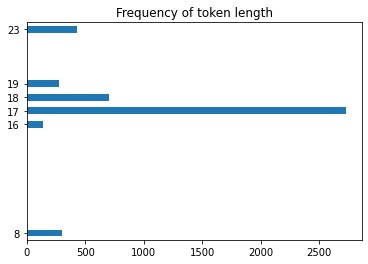

In [23]:
df["token_length"]= df["tokens"].apply(lambda x:len(x))
df["token_length"].value_counts().plot(kind="barh")
plt.title("Frequency of token length")

CPU times: user 2.25 s, sys: 44 ms, total: 2.29 s
Wall time: 2.29 s


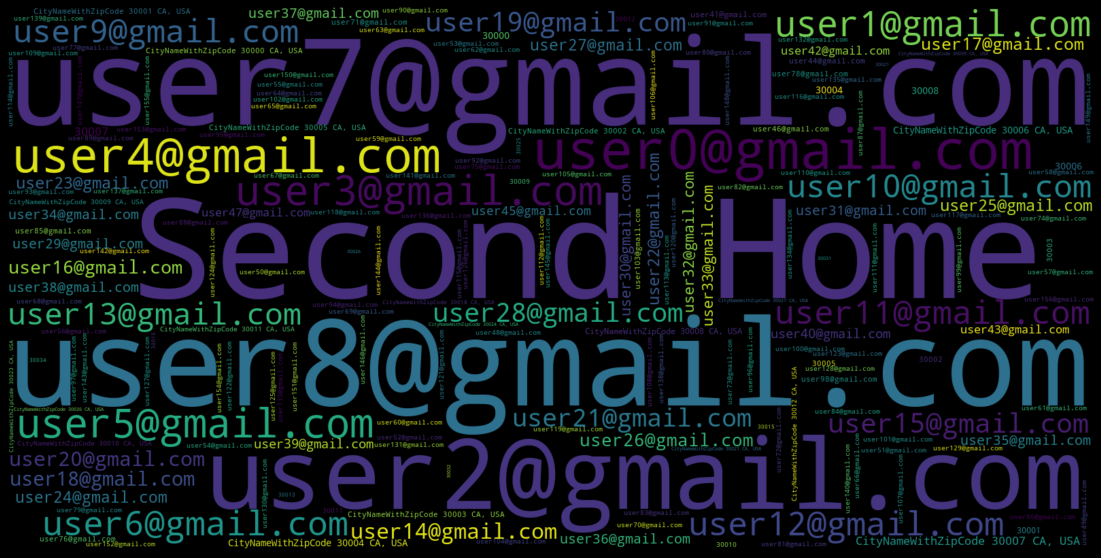

In [24]:
%%time

# create the WordCloud object
wordcloud = WordCloud(width=1600, height = 800)

# background_color='white'
freq_dict = {}
for idx, row in variable_df.iterrows():
    freq_dict[row["token"]] =row["df_count"]
wordcloud.generate_from_frequencies(frequencies=freq_dict)

#plot
plt.figure( figsize=(20,10), facecolor='k' )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.tight_layout(pad=0)
# plt.show()

plt.savefig('wordcloud.png', facecolor='k', bbox_inches='tight')

### 2. Replace the variables in the original dataframe 

"replaced_file_content" column is created by replaces variables in "file_content" with "__variable__"

In [25]:
def replace_variables(row, v):
    repl_word = "__variable__"
    for variable in v:
        row = row.replace(variable, "__variable__")
    return row

In [26]:
%%time
# replaced_file_content column is created by modifying 
# replacing the variables with __variable__
df["replaced_file_content"] = df["file_content"].apply(replace_variables, v=variables)

CPU times: user 2.4 s, sys: 1e+03 ns, total: 2.4 s
Wall time: 2.4 s


In [27]:
df["replaced_file_content"][0]

"  await goto('https://better.com/');\n  await click('See today\\'s rates');\n  await click('See rates', near('First, are you buying?'));\n  await click(near('I\\'m going to open houses'));\n  await click(near('See how much I can afford'));\n  await click(near('Not Sure'));\n  await write('__variable__', into(textBox('City, state, or zip'))) // <--- user entered text\n  await click('CityNameWithZipCode __variable__ CA, USA'); // <=== choice presented to user\n  await click('Next');\n  await click(near('Primary residence'));\n  await click(near('Single Family'));\n  await click('Next');\n  await write('__variable__', into(textBox(near('Email'))))\n  await click('Continue');\n"

In [28]:
df["replaced_file_content"][1]

"  await goto('https://better.com/');\n  await click('See today\\'s rates');\n  await click('See rates', near('First, are you buying?'));\n  await click(near('I\\'m going to open houses'));\n  await click(near('Estimate a home\\'s cost'));\n  await click(near('0–3 months'));\n  await write('__variable__', into(textBox('City, state, or zip'))) // <--- user entered text\n  await click('__variable__'); // <=== choice presented to user\n  await click('Next');\n  await click(near('Primary residence'));\n  await click(near('Single Family'));\n  await click('Next');\n  await write('__variable__', into(textBox(near('Email'))))\n  await click('Continue');\n"

Basic Intuition: 

Literals in click method are not variables and first literal in write method is usually a variable.
Threshold can be tuned by basic vizualization of few files at this step. 
If we see too many literals that are being replaced, we can lower the DF_THRESHOLD value at cell2.

In [29]:
# def replace_tokens(row, v):
#     repl_word = "__variable__"
#     row = [repl_word if t in v else t for t in row]
#     return row

In [30]:
# %%time
# # replaced_tokens column is created by replacing the variab with __variable__
# df["replaced_tokens"] = df["tokens"].apply(replace_tokens, v= variables)

In [31]:
# df["replaced_tokens"][0]

In [32]:
print("Total number of documents: ", len(df))
print("Total number of unique documents: ", df["file_content"].nunique())
print("Total number of unique documents after variable replacement: ", df["replaced_file_content"].nunique())

Total number of documents:  4561
Total number of unique documents:  4077
Total number of unique documents after variable replacement:  376


### 3. Find duplicate documents

#### 3.1 File content duplicates

In [33]:
df_duplicated = df[df.duplicated(["file_content"], keep=False)]
len(df_duplicated)

666

In [34]:
df_duplicated_agg = df_duplicated[["file_name", "file_content"]].astype(str).groupby('file_content').agg(','.join).reset_index().file_name
df_duplicated_agg

0      097062b6-bd8a-4586-ad5b-2fefdc564dc9.js,e7c919...
1      12ff2eea-4fe3-477a-8279-6f61dcd400e3.js,9d1062...
2      d0a8575b-a7a9-4ec0-a2ee-919ba54a7d27.js,3ba60e...
3      edcbe880-abe6-4258-a550-6362416e9bc0.js,d4b54e...
4      c99dfaad-dd32-4033-978e-6155d011def7.js,f1ef58...
                             ...                        
177    3fc1f8ce-423f-409c-b455-01339052db0f.js,c3feb9...
178    3c1b2a80-dd8b-4bcd-9a6d-bc8f4ff63599.js,9a4fdc...
179    0be269ae-27d6-4878-8c5a-694e40c01cec.js,f27a55...
180    c7dd58cf-35a4-44e3-83fe-ad7ab7f56b9d.js,6612d3...
181    5e008051-b56a-41c3-8294-70d1a0c0c7f7.js,028bb7...
Name: file_name, Length: 182, dtype: object

In [35]:
df_duplicated_agg.to_csv('file_content_duplicates.csv')

#### 3.2 Replaced File content duplicates

In [37]:
df_duplicated_replaced = df[df.duplicated(["replaced_file_content"], keep=False)]
len(df_duplicated_replaced)

4239

In [40]:
df_duplicates_agg_replaced = df_duplicated_replaced[["file_name", "replaced_file_content"]].astype(str).groupby('replaced_file_content').agg(','.join).reset_index().file_name
df_duplicates_agg_replaced.head()

0    512c59d2-30b3-4924-b2af-2f373e84ed8f.js,8f6fb8...
1    652781eb-79fa-4275-b55e-def7ff4ce2d7.js,adaf5e...
2    097062b6-bd8a-4586-ad5b-2fefdc564dc9.js,e7c919...
3    049b0552-8152-4281-a364-648318cc2b2f.js,f8b214...
4    c509b1c4-d2ae-4fb3-9f21-c94813c9ee0e.js,2b4081...
Name: file_name, dtype: object

In [ ]:
df_duplicates_agg_replaced.to_csv('replaced_file_content_duplicates.csv')